# 0. Setup Environement

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

%cd /content/drive/MyDrive/nyu-stuff/2023-fall/DS-UA\ 301\ Advanced\ DS/final_project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/nyu-stuff/2023-fall/DS-UA 301 Advanced DS/final_project


In [ ]:
%%capture
%pip install -r requirements.txt
%pip install wandb -Uq
import pandas
import numpy
import json5
import functools
import json
from matplotlib import pyplot
from typing import Optional, Any, Coroutine, Union, Dict, List
import nltk
from nltk.corpus import stopwords
import string
import contractions
import torch
import wandb
import sklearn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
nltk.download("stopwords")
nltk.download("punkt")

In [ ]:
def get_best_torch_device():
    if torch.cuda.is_available():  # CUDA
        return "cuda"
    elif torch.backends.mps.is_available():  # Apple Silicon / GPU
        return "mps"
    else:  # Fallback to CPU
        return "cpu"

# 1. Data Loading & Configure Hyperparameters

In [ ]:
# Configure hyperparameters (+ random state)
random_state = 13117
h_iter = 128
h_batch_size = 4096
h_test_size = 0.1
h_validation_size = 0.1
h_layers = 4
h_learning_rate = 0.005

device = get_best_torch_device()
print(f"Currently using {device.upper()} for training!")

Currently using CUDA for training!


In [ ]:
label_data = pandas.read_csv("data/balanced_with_labels.csv")

# Shuffle data
label_data = label_data.sample(frac=1, random_state=random_state)


# Base on results from eye-balling the dataset,
# people seem to have a hard time giving intermediate (2 and 4) ratings,
# lets flat them.
def get_flat_value(input_val):
    if input_val < 2:
        return 1
    elif input_val < 4:
        return 3
    else:
        return 5


label_data["rating"] = [get_flat_value(x) for x in label_data["rating"]]
display(label_data.head(10))

,review_text,rating,length,good,decent,mediocre,bad,horrible
35243,The case is a very tight fit and the back remi...,5,123,0.360874,0.225490,0.075706,0.316110,0.021820
29126,"Works fine, but I had to put a few locking sq...",3,137,0.262977,0.723278,0.008984,0.003572,0.001188
28232,I purchased this item along with DKnight and A...,3,923,0.385126,0.376884,0.068360,0.159016,0.010614
22265,Corner Tabs feels like it is going to break/sn...,3,209,0.711987,0.235765,0.024387,0.023371,0.004490
6891,"Did not work at all, went to walmart and bough...",1,422,0.009885,0.010234,0.113022,0.600792,0.266068
2317,Purchased this case for the Lumia 1020 because...,1,611,0.024491,0.013958,0.337273,0.433872,0.190405
29361,"it is just ok, i guess, it is at my desk, i ch...",3,105,0.031582,0.353640,0.612850,0.001231,0.000697
20274,Works as advertized but only support one phone...,3,624,0.083988,0.436971,0.393090,0.082832,0.003119
43840,like the title says.I love this case.My note 1...,5,100,0.632552,0.364548,0.001383,0.000879,0.000638
4412,"I have to revise my opinion of this earpiece, ...",1,322,0.053848,0.008828,0.029792,0.574338,0.333193


In [ ]:
train_set, tmp_set = train_test_split(
    label_data, test_size=h_test_size + h_validation_size, random_state=random_state
)
test_set, validation_set = train_test_split(
    tmp_set,
    test_size=h_validation_size / (h_validation_size + h_test_size),
    random_state=random_state,
)
# train_set = label_data.sample(frac=1 - h_test_size, random_state=random_state)
# test_set = label_data.sample(frac=h_test_size, random_state=random_state)

In [ ]:
class FairDataset(torch.utils.data.Dataset):
    def __init__(self, df_input):
        df_x = df_input[
            [
                c
                for c in df_input.columns
                if c not in ["review_text", "rating", "length"]
            ]
        ]
        df_y = df_input["rating"]
        self.features = torch.tensor(df_x.values, dtype=torch.float32).to(device)
        self.labels = torch.tensor(df_y.values, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
ds_train = FairDataset(train_set)
ds_test = FairDataset(test_set)
ds_validation = FairDataset(validation_set)

In [ ]:
print("# of samples in train set:", len(ds_train))
print("# of samples in test set:", len(ds_test))
print("# of samples in validation set:", len(ds_validation))

# of samples in train set: 40000
# of samples in test set: 5000
# of samples in validation set: 5000


# 2. Define and Train Model

In [ ]:
def spawn_layers(
    n_layers,
    input_size,
    output_size,
    is_batch_norm=True,
    activation_func=nn.ReLU,
    output_func=nn.LogSoftmax,
):
    layers = []
    prev_hidden = input_size

    for i in range(n_layers):
        hidden_size = int((prev_hidden + output_size) / 2)

        layers += [
            nn.Linear(in_features=prev_hidden, out_features=hidden_size),
            nn.BatchNorm1d(hidden_size) if is_batch_norm else nn.Identity(),
            activation_func(),
        ]

        prev_hidden = hidden_size

    return layers + [output_func(dim=1)]

In [ ]:
sample_input, sample_output = ds_train[0]

input_size = len(sample_input)
output_size = len(str(sample_output))

In [ ]:
columns = ["epoch", "train_loss", "val_loss", "val_accuracy"]


loader_test = DataLoader(ds_test, batch_size=h_batch_size, shuffle=False)
loader_validation = DataLoader(ds_validation, batch_size=h_batch_size, shuffle=False)


def train_node(params):
    rows = []
    batch_size = params["batch_size"]
    n_layers = params["n_layers"]
    learning_rate = params["learning_rate"]
    n_epochs = params["n_epochs"]
    is_batch_norm = params["is_batch_norm"]

    optimizer_func = (
        torch.optim.Adam if params["optimizer"] == "adam" else torch.optim.SGD
    )
    activation_func = (
        nn.LeakyReLU if params["activation_func"] == "leaky_relu" else nn.ReLU
    )

    loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

    # Intialize Model
    model = nn.Sequential(
        *spawn_layers(
            n_layers,
            input_size,
            output_size,
            activation_func=activation_func,
            is_batch_norm=is_batch_norm,
        )
    ).to(device)

    # Initalize Optimizer (Adam in this case)
    optimizer = optimizer_func(model.parameters(), lr=learning_rate)

    # Initialize Loss Function
    criterion = nn.CrossEntropyLoss()

    best_val_loss = -1
    best_chkpt = None
    best_accuracy = -1

    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode

        loss = None
        val_loss = None
        for inputs, labels in loader_train:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels.long())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Validation after each epoch
        model.eval()
        correct = 0
        total = 0

        # Get validation loss and accuracy
        with torch.no_grad():
            for inputs, labels in loader_validation:
                outputs = model(inputs)
                val_loss = criterion(outputs, labels.long())

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        val_loss_num = val_loss.item()

        # Save the model with minimum val loss
        if best_val_loss == -1 or val_loss_num < best_val_loss:
            best_val_loss = val_loss_num
            best_accuracy = val_accuracy
            best_chkpt = {
                "params": params,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "loss": loss,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy,
            }

        # Print telemetry data
        print(
            f"\rEpoch [{epoch+1}/{n_epochs}] train_loss: {loss.item():.4f},"
            f"val_loss: {val_loss.item():.4f},"
            f"val_acc: {val_accuracy}",
            end="",
        )

        rows.append([epoch, loss.item(), val_loss.item(), val_accuracy])

    df_results = pandas.DataFrame(rows, columns=columns)
    print("")

    return df_results, best_val_loss, best_accuracy, best_chkpt, model

In [ ]:
h_optimizer = "adam"

df_results, best_val_loss, best_accuracy, best_chkpt, model = train_node(
    {
        "batch_size": h_batch_size,
        "n_layers": h_layers,
        "learning_rate": h_learning_rate,
        "n_epochs": h_iter,
        "optimizer": h_optimizer,
        "is_batch_norm": True,
        "activation_func": "leaky_relu",
    }
)

Epoch [128/128] train_loss: 0.6759,val_loss: 0.7235,val_acc: 0.7188


Text(0.5, 1.0, 'Losses vs Number of Epochs')

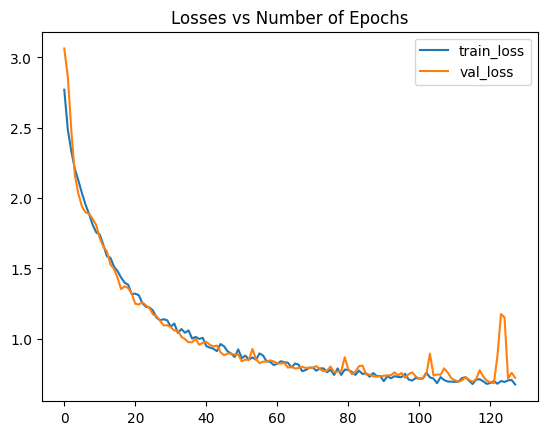

In [ ]:
pyplot.plot(df_results["train_loss"], label="train_loss")
pyplot.plot(df_results["val_loss"], label="val_loss")
pyplot.legend()
pyplot.title(f"Losses vs Number of Epochs")

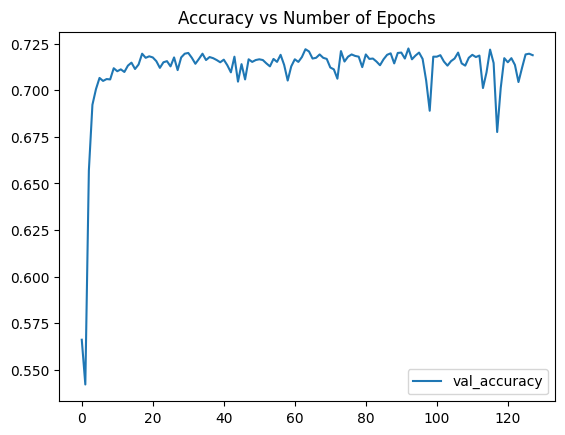

In [ ]:
pyplot.plot(df_results["val_accuracy"], label="val_accuracy")
pyplot.title(f"Accuracy vs Number of Epochs")
pyplot.legend()

# 3. Hyperparameter Tuning

In [ ]:
params = {
    "learning_rate": [0.1, 0.005, 0.01],
    "optimizer": ["adam", "sgd"],
    "n_layers": [2, 3, 4],
    "is_batch_norm": [True],
    "activation_func": ["relu", "leaky_relu"],
    "n_epochs": [128],
    "batch_size": [8192,4096],
}

sweep_config = {
    "method": "random",
    "metric": {"name": "loss", "goal": "minimize"},
}

sweep_config["parameters"] = {k: {"values": v} for k, v in params.items()}

In [ ]:
wandb.login()

loss_mp = {}


def train_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        result_df, val_loss, val_acc, chkpt, model = train_node(config)

        # Get test accuracy
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in loader_test:
                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = correct / total

        loss_mp[val_loss] = {
            "config": config,
            "result_df": result_df,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "test_acc": test_acc,
            "chkpt": chkpt,
        }

        wandb.log({"loss": val_loss})

wandb: Currently logged in as: lbypatrick. Use `wandb login --relogin` to force relogin


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="FAIR_sweep_final_2")
wandb.agent(sweep_id, train_wandb, count=32)

Create sweep with ID: rhzb5q9b
Sweep URL: https://wandb.ai/lbypatrick/FAIR_sweep_final_2/sweeps/rhzb5q9b


wandb: Agent Starting Run: 1372yscz with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 1.1910,val_loss: 1.1809,val_acc: 0.7146


loss,▁
loss,1.18093


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7pa213cd with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.6364,val_loss: 0.7102,val_acc: 0.7108


loss,▁
loss,0.60888


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i0pjltqu with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.6861,val_loss: 0.6771,val_acc: 0.7212


loss,▁
loss,0.67251


wandb: Agent Starting Run: eu43s51b with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.6857,val_loss: 0.6469,val_acc: 0.715


loss,▁
loss,0.64632


wandb: Agent Starting Run: 7ihp6lb5 with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.7061,val_loss: 0.6832,val_acc: 0.722


loss,▁
loss,0.67147


wandb: Agent Starting Run: jv2tu4gu with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 1.7007,val_loss: 1.6503,val_acc: 0.7122


loss,▁
loss,1.65028


wandb: Agent Starting Run: nzi5rz4c with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.6952,val_loss: 0.7089,val_acc: 0.6982


loss,▁
loss,0.69312


wandb: Agent Starting Run: rpilpexp with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 1.6594,val_loss: 1.6211,val_acc: 0.7136


loss,▁
loss,1.62107


wandb: Agent Starting Run: 8ctb6ps2 with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.8363,val_loss: 0.7994,val_acc: 0.7186


loss,▁
loss,0.79876


wandb: Agent Starting Run: bo61691w with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.6556,val_loss: 0.6407,val_acc: 0.7168


loss,▁
loss,0.64072


wandb: Agent Starting Run: luvw6ja7 with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.9324,val_loss: 0.9303,val_acc: 0.7162


loss,▁
loss,0.93031


wandb: Agent Starting Run: 2xjg7od1 with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.7959,val_loss: 0.8794,val_acc: 0.6852


loss,▁
loss,0.8267


wandb: Agent Starting Run: fpeyr8ni with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.9633,val_loss: 0.9006,val_acc: 0.7192


loss,▁
loss,0.90057


wandb: Agent Starting Run: x295thqj with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.7029,val_loss: 0.6955,val_acc: 0.7168


loss,▁
loss,0.67185


wandb: Agent Starting Run: 1s7m29hl with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.6333,val_loss: 0.7294,val_acc: 0.658


loss,▁
loss,0.64074


wandb: Agent Starting Run: iz78lz9b with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.8025,val_loss: 0.8233,val_acc: 0.7016


loss,▁
loss,0.80377


wandb: Agent Starting Run: 4e8to26p with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.6961,val_loss: 0.7070,val_acc: 0.7052


loss,▁
loss,0.6821


wandb: Agent Starting Run: xrqk6bw9 with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.6426,val_loss: 0.6322,val_acc: 0.718


loss,▁
loss,0.63221


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lm0ar9th with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.6825,val_loss: 0.6754,val_acc: 0.7204


loss,▁
loss,0.67276


wandb: Agent Starting Run: fpb5sitj with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.6787,val_loss: 0.6546,val_acc: 0.7086


loss,▁
loss,0.63731


wandb: Agent Starting Run: o6u41vzy with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 1.2436,val_loss: 1.2129,val_acc: 0.7196


loss,▁
loss,1.21286


wandb: Agent Starting Run: i0392zbl with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.7003,val_loss: 0.6998,val_acc: 0.717


loss,▁
loss,0.68014


wandb: Agent Starting Run: 4ydxanld with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.8121,val_loss: 0.7971,val_acc: 0.7176


loss,▁
loss,0.79713


wandb: Agent Starting Run: 1n1ay483 with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 3
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.6140,val_loss: 0.6841,val_acc: 0.718


loss,▁
loss,0.60311


wandb: Agent Starting Run: 5ct8x31j with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 1.6361,val_loss: 1.5969,val_acc: 0.7114


loss,▁
loss,1.59688


wandb: Agent Starting Run: s7x1ifn4 with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.6790,val_loss: 0.6458,val_acc: 0.7152


loss,▁
loss,0.64461


wandb: Agent Starting Run: nobc6jng with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.6200,val_loss: 0.6233,val_acc: 0.7118


loss,▁
loss,0.6104


wandb: Agent Starting Run: gudregz2 with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.1
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.6159,val_loss: 0.6851,val_acc: 0.6878


loss,▁
loss,0.60428


wandb: Agent Starting Run: rmgffwhz with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.8224,val_loss: 0.9205,val_acc: 0.7038


loss,▁
loss,0.81662


wandb: Agent Starting Run: 9ysfkrdz with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.005
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.7993,val_loss: 0.9040,val_acc: 0.7106


loss,▁
loss,0.87194


wandb: Agent Starting Run: 6gb9y7om with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 4096
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 4
wandb: 	optimizer: sgd


Epoch [128/128] train_loss: 0.9142,val_loss: 0.9131,val_acc: 0.7188


loss,▁
loss,0.91308


wandb: Agent Starting Run: 26j46cxc with config:
wandb: 	activation_func: leaky_relu
wandb: 	batch_size: 8192
wandb: 	is_batch_norm: True
wandb: 	learning_rate: 0.01
wandb: 	n_epochs: 128
wandb: 	n_layers: 2
wandb: 	optimizer: adam


Epoch [128/128] train_loss: 0.6912,val_loss: 0.7727,val_acc: 0.695


loss,▁
loss,0.70034


In [ ]:
cleaned_loss_mp = {}

for k, v in loss_mp.items():

  v["chkpt"]["params"] = dict(v["chkpt"]["params"])
  v["config"] = dict(v["config"])

  cleaned_loss_mp[k] = v

In [ ]:
torch.save(cleaned_loss_mp, "sweep_result_loss_mp_fast_final_2.pickle")